In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
from time import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score, roc_auc_score

# pd.set_option("display.max_columns", None)
# pd.set_option('display.max_rows', None)

In [2]:
# Load data
df = pd.read_csv('census.csv')
df.head()

age          workclass education_level  education-num       marital-status  \
0   39          State-gov       Bachelors           13.0        Never-married   
1   50   Self-emp-not-inc       Bachelors           13.0   Married-civ-spouse   
2   38            Private         HS-grad            9.0             Divorced   
3   53            Private            11th            7.0   Married-civ-spouse   
4   28            Private       Bachelors           13.0   Married-civ-spouse   

           occupation    relationship    race      sex  capital-gain  \
0        Adm-clerical   Not-in-family   White     Male        2174.0   
1     Exec-managerial         Husband   White     Male           0.0   
2   Handlers-cleaners   Not-in-family   White     Male           0.0   
3   Handlers-cleaners         Husband   Black     Male           0.0   
4      Prof-specialty            Wife   Black   Female           0.0   

   capital-loss  hours-per-week  native-country income  
0           0.0            40.0   United-States  <=50K  
1           0.0            13.0   United-States  <=50K  
2           0.0            40.0   United-States  <=50K  
3           0.0            40.0   United-States  <=50K  
4           0.0            40.0            Cuba  <=50K

# I. Explore data

## Check duplicates

In [3]:
df.duplicated().sum()

5982

- There are 5982 duplicated rows, let's remove them

In [4]:
df.drop_duplicates(inplace=True)
df.duplicated().sum() # test

0

## Check dtypes

In [5]:
df.dtypes

age                  int64
workclass           object
education_level     object
education-num      float64
marital-status      object
occupation          object
relationship        object
race                object
sex                 object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
income              object
dtype: object

## Basic stats

- Numeric cols:

In [6]:
def missing_ratio(s):
    return s.isna().sum() * 100 / len(s)

num_cols = df.select_dtypes([np.int64, np.float64]).columns.tolist()
df[num_cols].agg([missing_ratio, pd.Series.min, pd.Series.max, pd.Series.nunique])

age  education-num  capital-gain  capital-loss  hours-per-week
missing_ratio   0.0            0.0           0.0           0.0             0.0
min            17.0            1.0           0.0           0.0             1.0
max            90.0           16.0       99999.0        4356.0            99.0
nunique        74.0           16.0         121.0          97.0            96.0

- Categorical cols:

In [7]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
df[cat_cols].agg([missing_ratio, pd.Series.nunique, pd.Series.unique])

workclass  \
missing_ratio                                                0.0   
nunique                                                        7   
unique         [ State-gov,  Self-emp-not-inc,  Private,  Fed...   

                                                 education_level  \
missing_ratio                                                0.0   
nunique                                                       16   
unique         [ Bachelors,  HS-grad,  11th,  Masters,  9th, ...   

                                                  marital-status  \
missing_ratio                                                0.0   
nunique                                                        7   
unique         [ Never-married,  Married-civ-spouse,  Divorce...   

                                                      occupation  \
missing_ratio                                                0.0   
nunique                                                       14   
unique         [ Adm-clerical,  Exec-managerial,  Handlers-cl...   

                                                    relationship  \
missing_ratio                                                0.0   
nunique                                                        6   
unique         [ Not-in-family,  Husband,  Wife,  Own-child, ...   

                                                            race  \
missing_ratio                                                0.0   
nunique                                                        5   
unique         [ White,  Black,  Asian-Pac-Islander,  Amer-In...   

                            sex  \
missing_ratio               0.0   
nunique                       2   
unique         [ Male,  Female]   

                                                  native-country  \
missing_ratio                                                0.0   
nunique                                                       41   
unique         [ United-States,  Cuba,  Jamaica,  India,  Mex...   

                      income  
missing_ratio            0.0  
nunique                    2  
unique         [<=50K, >50K]

## Check distribution & relation

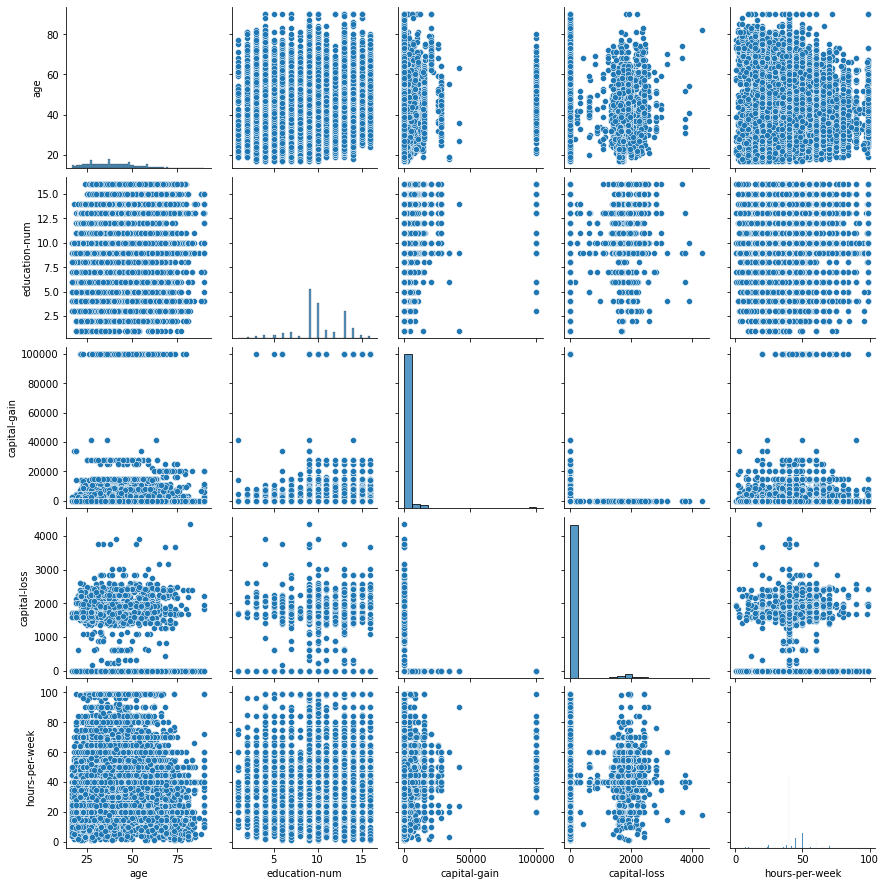

In [8]:
sns.pairplot(df)

- Zoom in `age` & `hours-per-week`

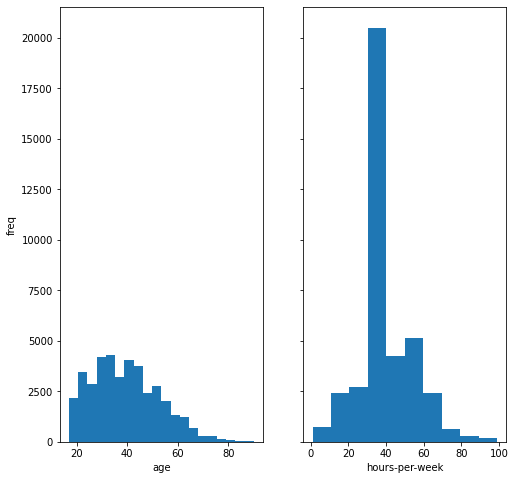

In [9]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,8))
ax[0].hist(df['age'], bins=20)
ax[0].set_xlabel('age')
ax[0].set_ylabel('freq')
ax[1].hist(df['hours-per-week'])
ax[1].set_xlabel('hours-per-week');

$\to$ Frequency of (`hours-per-week` = 40) seems suspicious (too high). Let's plot boxplot to see whether there are any outliers

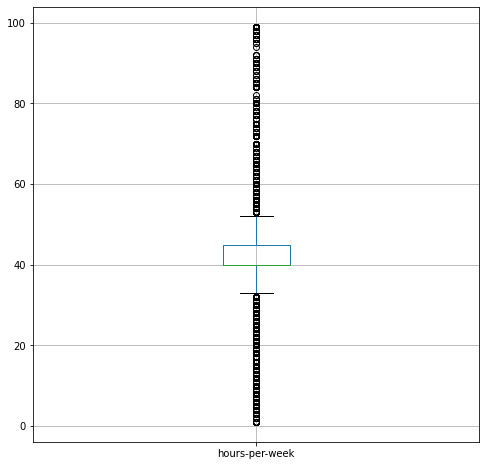

In [10]:
df.boxplot('hours-per-week', figsize=(8,8));

$\to$ To many outliers!

# Conclusion
In the next stage, consider:
- Normalize all numeric data
- Encode all categorical data
- The target col (`income`) should be mapped into 1 & 0
- `age`, `capital-loss`, `capital-gain` are skewed to the right
- `hours-per-week` has outliers

## II. Preprocessing

- Let's not know too deep about the validation data by splitting `df` into train & validation set

In [11]:
y_sr = df["income"] 
X_df = df.drop("income", axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_df, y_sr, test_size=0.2, random_state=0)
X_train.shape, X_val.shape

((31392, 13), (7848, 13))

## 1. `hours-per-week` has outliers

- Because `hours-per-week`'s distribution is close to normal distribution, so just take 3 standard deviation from the mean

In [12]:
mean, std = df['hours-per-week'].mean(), df['hours-per-week'].std()
df = df[df['hours-per-week'] <= (mean + 3*std)]
df = df[df['hours-per-week'] >= (mean - 3*std)]

## 2. Create a preprocessing pipeline

The order we should preprocess: 
- Encode categorical data, so that categorical data is converted to numeric
- For original numeric cols, use log(n+1) (`np.log1p`) to remove skewness
- Finally, when the input is all numeric, apply `MaxAbsScaler` method to scale the data

In [13]:
skewed_cols = ['age', 'capital-loss', 'capital-gain']
cat_cols.remove('income')

cat_transform = Pipeline([('cat_imputer', SimpleImputer(strategy='most_frequent')),
                          ('encoder', OneHotEncoder())])
num_transform = Pipeline([('med_imputer', SimpleImputer(strategy='median')), 
                          ('skewed_data_transformer', FunctionTransformer(np.log1p))])

preprocess_pipeline = Pipeline([
    ('column_transform', ColumnTransformer([('cat_transform', cat_transform, cat_cols),
                                            ('skewed_data_transformer', num_transform, skewed_cols)], 
                                           remainder='passthrough')),
    ('scaler', MaxAbsScaler())
])

<font color='red'>Note</font>: Thanks to the data exploration in section IV, the real test set (test_census.csv) contains missing values in both numeric & categorical cols, that's why imputers are added to the `preprocess_pipeline`

In [14]:
preprocess_pipeline.fit_transform(X_train) # test

<31392x103 sparse matrix of type '<class 'numpy.float64'>'
	with 350043 stored elements in Compressed Sparse Row format>

## 3. The target col (`income`) should be mapped into 1 & 0

- Because this problem is related to target col, so we cannot add this step to the pipeline above. But we can create a function that can preprocess both **feature cols** & **target col**. Let's name the function `preprocess`

In [15]:
def preprocess(X_df, y_sr, preprocess_pipeline, fit_transform=False):
    '''Preprocess X_df & y_sr
        For X_df (train/validation):
            - Encode categorical cols
            - Remove skewness of ['age', 'capital-loss', 'capital-gain']
            - Scaling
        For y_sr: Map to 0 & 1
    '''
    # preprocess X_df
    if fit_transform: # train_set
        preprocessed_X = preprocess_pipeline.fit_transform(X_df)
    else: # validation_set
        preprocessed_X = preprocess_pipeline.transform(X_df)
    
    # preprocess y_sr
    preprocessed_y = y_sr.map({'>50K': 1, '<=50K': 0})
    
    return preprocessed_X, preprocessed_y

# III. ML models

- Prepare the input

In [16]:
preprocessed_X_train, preprocessed_y_train = preprocess(X_train, y_train, preprocess_pipeline, fit_transform=True)
preprocessed_X_val, preprocessed_y_val = preprocess(X_val, y_val, preprocess_pipeline)

- Generalize the training & predicting phase of all models

In [17]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
   '''
   inputs:
      - learner: the learning algorithm to be trained and predicted on
      - sample_size < 1: the size of samples (number) to be drawn from training set
      - X_train: features training set (assume preprocessed)
      - y_train: income training set
      - X_test: features testing set (assume preprocessed)
      - y_test: income testing set
   output: a dictionary with each key:
      - train_time, pred_time
      - acc_train, auc_train: accuracy & auc of the prediction of the first 300 training samples
      - acc_test, auc_test
   '''
   results = {}
   
   # Fitting (training) phase
   start = time() 
   learner = learner.fit(X_train[:int(X_train.shape[0]*sample_size)], y_train[:int(X_train.shape[0]*sample_size)])
   end = time() 
   results['train_time'] = end - start 
   # breakpoint()
   
   # prediction phase
   start = time() 
   predictions_test = learner.predict(X_test)
   predictions_train = learner.predict(X_train[:300])
   end = time()
   results['pred_time'] = end - start
   # breakpoint()
         
   # accuracy
   results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
   results['acc_test'] = accuracy_score(y_test, predictions_test)
   
   # AUC (always < 1)
   results['auc_train'] = roc_auc_score(y_train[:300], predictions_train)
   results['auc_test'] = roc_auc_score(y_test, predictions_test)
      
   # verbose
   print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
      
   return results

- Init 3 models

In [18]:
clf_A = RandomForestClassifier(random_state=42)
clf_B = GradientBoostingClassifier(random_state=42)
clf_C = xgb.XGBClassifier(random_state=42)

In [19]:
samples_100 = len(y_train)
samples_10 = 0.1*len(y_train)
samples_1 = 0.01*len(y_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, preprocessed_X_train, preprocessed_y_train, 
                                                           preprocessed_X_val, preprocessed_y_val)

RandomForestClassifier trained on 313.92 samples.
RandomForestClassifier trained on 3139.2000000000003 samples.
RandomForestClassifier trained on 31392 samples.
GradientBoostingClassifier trained on 313.92 samples.
GradientBoostingClassifier trained on 3139.2000000000003 samples.
GradientBoostingClassifier trained on 31392 samples.
[10:26:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier trained on 313.92 samples.
[10:26:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier trained on 3139.2000000000003 samples.
[10:26:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier trained on 31392 samples.


- Plotting 3 models based on certain criteria: time, acccuracy, AUC

In [20]:
def evaluate(results):
    import matplotlib.patches as mpatches
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (11,7))
    # Constants
    bar_width = 0.3
    colors = ['navy','yellow','green']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'auc_train', 'pred_time', 'acc_test', 'auc_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("AUC")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("AUC")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("AUC on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Validation Set")
    ax[1, 2].set_title("AUC on Validation Set")

    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))
    plt.tight_layout()
    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.07)
    plt.show()


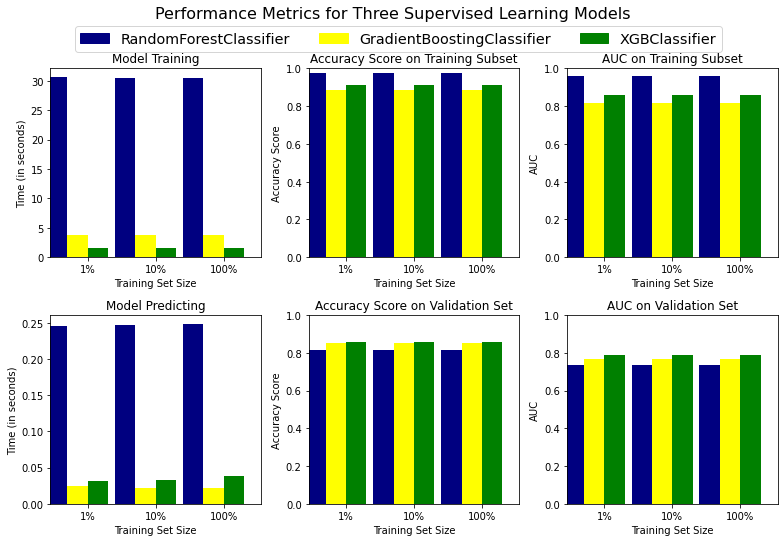

In [21]:
evaluate(results)

Some comments about the above chart: 
- Time: Random Forest is the worst as its training & predicting time for any subsets of training set (1%, 10%, 100%) are the highest bars
- Accuracy: Random Forest achieves the highest accuracy only on training set and works less efficient on validation set compared to the other 2 models. In other words, Random forest is overfitted while the other 2 models are well-fitted on the validation set (and it's hard to see which one is better at predicting validation data from the second-vertical images). 
- AUC: This one shows clearly that Random forest is overfitted. Besides, `XGBClassifier` is the best predictor as it has the highest AUC on validation set

In [22]:
best_model = results['XGBClassifier']
best_model

{0: {'train_time': 1.6082909107208252,
  'pred_time': 0.03191399574279785,
  'acc_train': 0.91,
  'acc_test': 0.8588175331294597,
  'auc_train': 0.8568322981366461,
  'auc_test': 0.7870370474637631},
 1: {'train_time': 1.5757837295532227,
  'pred_time': 0.03291153907775879,
  'acc_train': 0.91,
  'acc_test': 0.8588175331294597,
  'auc_train': 0.8568322981366461,
  'auc_test': 0.7870370474637631},
 2: {'train_time': 1.615675687789917,
  'pred_time': 0.03789925575256348,
  'acc_train': 0.91,
  'acc_test': 0.8588175331294597,
  'auc_train': 0.8568322981366461,
  'auc_test': 0.7870370474637631}}

## Model tunning

- Use Random Search to find the best hyperparameters
- The list of hyperparameters: https://xgboost.readthedocs.io/en/stable/parameter.html (Section 'Parameters for Tree Booster')

In [ ]:
parameters = {
    "eta" : [0.1, 0.15, 0.5, 1], # learning rate
    "n_estimators": [300, 400],
    'max_depth': [3, 5, 6],
    'gamma' : [0.05, 0.1, 0.15, 0.3],
    'max_delta_step' : [0, 1, 3, 5, 7,9],
    'lambda': [0.1, 0.5, 0.7, 1]
}

clf = xgb.XGBClassifier(random_state=42)
random_search = RandomizedSearchCV(clf, parameters).fit(preprocessed_X_train, preprocessed_y_train)
best_clf = random_search.best_estimator_

In [24]:
best_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.15, gamma=0.3, gpu_id=-1, importance_type=None,
              interaction_constraints='', lambda=0.1, learning_rate=0.150000006,
              max_delta_step=1, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=0.100000001, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

- When defining 2 variables `auc_predictions`, `auc_best_predictions`, we should use `predict_proba()` since when calculating **Area** under the curve (AUC), it is more accurate to not round the number down to 0 or 1
- Ref: https://stats.stackexchange.com/questions/254710/is-it-better-to-compute-a-roc-curve-using-predicted-probabilities-or-distances-f 

In [25]:
y_pred = (clf.fit(preprocessed_X_train, preprocessed_y_train)).predict(preprocessed_X_val)
auc_predictions = (clf.fit(preprocessed_X_train, preprocessed_y_train)).predict_proba(preprocessed_X_val)[:,1]

y_best_pred = best_clf.predict(preprocessed_X_val)
auc_best_predictions = best_clf.predict_proba(preprocessed_X_val)[:,1]

print("Untunned model\n------")
print(f"Accuracy score on validation data: {accuracy_score(preprocessed_y_val, y_pred)}")
print(f"AUC on testing data: {roc_auc_score(preprocessed_y_val, auc_predictions)}")
print("\nTunned Model\n------")
print(f"Final accuracy score on the testing data: {accuracy_score(preprocessed_y_val, y_best_pred)}")
print(f"Final AUC on the testing data: {roc_auc_score(preprocessed_y_val, auc_best_predictions)}")

[10:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Untunned model
------
Accuracy score on validation data: 0.8588175331294597
AUC on testing data: 0.9189227302883551

Tunned Model
------
Final accuracy score on the testing data: 0.8628950050968399
Final AUC on the testing data: 0.919740615520572


$\to$ Better than 1% :)

# IV. Deal with test_census.csv

In [27]:
X_test = pd.read_csv('test_census.csv')
X_test.drop(['Unnamed: 0'] , axis=1, inplace=True)
X_test.head()

age          workclass education_level  education-num  \
0  21.0            Private            10th            6.0   
1  49.0            Private       Bachelors           13.0   
2  44.0   Self-emp-not-inc      Assoc-acdm           12.0   
3  34.0            Private       Bachelors           13.0   
4  24.0            Private         HS-grad            9.0   

        marital-status          occupation relationship    race      sex  \
0   Married-civ-spouse        Craft-repair      Husband   White     Male   
1   Married-civ-spouse        Adm-clerical         Wife   White   Female   
2   Married-civ-spouse       Other-service         Wife   White   Female   
3   Married-civ-spouse               Sales      Husband   White     Male   
4   Married-civ-spouse   Machine-op-inspct      Husband   White     Male   

   capital-gain  capital-loss  hours-per-week  native-country  
0           0.0           0.0            40.0   United-States  
1           0.0           0.0            40.0   United-States  
2           0.0           0.0            99.0   United-States  
3        7298.0           0.0            46.0   United-States  
4           0.0           0.0            40.0   United-States

## Data exploration

In [32]:
X_test.agg([missing_ratio])

age  workclass  education_level  education-num  \
missing_ratio  0.037592   0.048649         0.044226       0.030958   

               marital-status  occupation  relationship      race       sex  \
missing_ratio        0.046438    0.048649      0.035381  0.042015  0.042015   

               capital-gain  capital-loss  hours-per-week  native-country  
missing_ratio       0.03317      0.037592        0.028747        0.035381

## Preprocess X_test

In [31]:
preprocessed_X_test = preprocess_pipeline.transform(X_test)

## Training & exporting prediction to a file

- Join `X_train` & `X_val` into 1 single large train set (make use of all training data). This is `X_df` (but hasn't been preprocessed yet)

In [36]:
preprocessed_X_train, preprocessed_y_train = preprocess(X_df, y_sr, preprocess_pipeline, fit_transform=True)
preprocessed_X_train.shape, preprocessed_y_train.shape

((39240, 103), (39240,))

- Training phase

In [37]:
y_test_pred = (best_clf.fit(preprocessed_X_train, preprocessed_y_train)).predict(preprocessed_X_test)
y_test_pred

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:38:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [41]:
final = pd.DataFrame(list(y_test_pred), columns = ['income'])
final = final.reset_index()
final.rename(columns={"index":"id"}, inplace = True)
final.to_csv('final.csv', index=False)
final.head()

id  income
0   0       0
1   1       1
2   2       0
3   3       1
4   4       0